# Home Advantage in Football Matches

### Goal:
Analyze the dataset to determine if there is a measurable advantage for teams playing at home across different leagues and seasons. 
We'll explore trends across leagues and seasons, using data from the Kaggle Soccer dataset.


In [12]:
import kagglehub
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 1: Download the dataset
path = kagglehub.dataset_download("hugomathien/soccer")

# Step 2: Construct the path to the SQLite database
db_file = os.path.join(path, "database.sqlite")

# Step 3: Connect to the SQLite database
try:
    conn = sqlite3.connect(db_file)
except sqlite3.OperationalError as e:
    print(f"Error: {e}")
    exit()

In [7]:
query = """
SELECT 
    home_team_goal, 
    away_team_goal, 
    league_id, 
    season, 
    home_team_api_id, 
    away_team_api_id
FROM Match
"""
matches = pd.read_sql(query, conn)
print(matches.head())

   home_team_goal  away_team_goal  league_id     season  home_team_api_id  \
0               1               1          1  2008/2009              9987   
1               0               0          1  2008/2009             10000   
2               0               3          1  2008/2009              9984   
3               5               0          1  2008/2009              9991   
4               1               3          1  2008/2009              7947   

   away_team_api_id  
0              9993  
1              9994  
2              8635  
3              9998  
4              9985  


# Exploratory Data Analysis (EDA)


Average Home Goals: 1.5445937103044767
Average Away Goals: 1.1609376804341969

Match Outcome Percentages:
result
Win     45.871666
Loss    28.738597
Draw    25.389738
Name: proportion, dtype: float64


C:\Users\damia\AppData\Local\Temp\ipykernel_4388\920892311.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=matches, x='result', order=['Win', 'Draw', 'Loss'], palette=custom_palette)


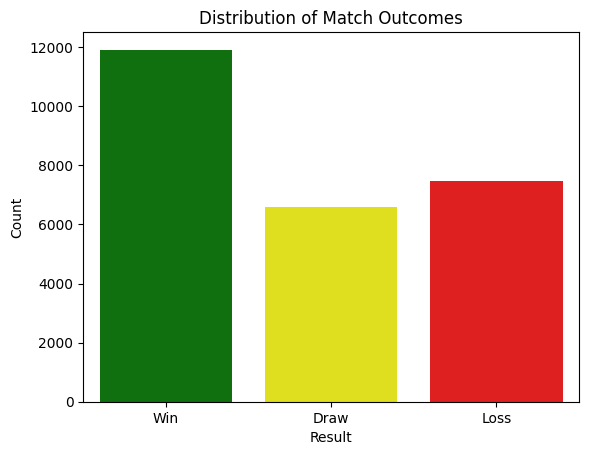

In [15]:
home_avg_goals = matches['home_team_goal'].mean()
away_avg_goals = matches['away_team_goal'].mean()
print(f"\nAverage Home Goals: {home_avg_goals}")
print(f"Average Away Goals: {away_avg_goals}")
matches['result'] = matches.apply(
    lambda row: 'Win' if row['home_team_goal'] > row['away_team_goal']
    else 'Loss' if row['home_team_goal'] < row['away_team_goal']
    else 'Draw', axis=1
)
result_counts = matches['result'].value_counts(normalize=True) * 100
print("\nMatch Outcome Percentages:")
print(result_counts)
custom_palette = {
    "Win": "green",
    "Draw": "yellow",
    "Loss": "red"
}
sns.countplot(data=matches, x='result', order=['Win', 'Draw', 'Loss'], palette=custom_palette)
plt.title("Distribution of Match Outcomes")
plt.xlabel("Result")
plt.ylabel("Count")
plt.show()